In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import scanpy as sc
import numpy as np
import scvi
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import poisson_atac as patac
from scipy.sparse import csr_matrix

Global seed set to 0


In [3]:
adata = sc.read_h5ad("/storage/groups/ml01/workspace/dominik.klein/scMultiome_NVF/scMultiome_NVF_E14-E15/E14-E15_ATAC_annotated.h5ad")

In [4]:
adata

AnnData object with n_obs × n_vars = 16978 × 261915
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'doublet_calls', 'final_doublets', 'final_doublets_cat', 'nCount_peaks', 'nFeature_peaks', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'peaks.weight', 'sample', 'ident', 'old_index', 'celltype'
    var: 'count', 'percentile'
    uns: 'X_name'
    obsm: 'LSI', 'UMAP.ATAC'
    layers: 'logcounts'

# Embed ATAC

In [5]:
n_peaks_before = adata.shape[1]

In [6]:
sc.pp.filter_genes(adata, min_cells=int(adata.shape[0]*0.01))

In [7]:
print(f"filtered {n_peaks_before - adata.n_vars} peaks.")

filtered 97833 peaks.


In [8]:
adata.layers["ATAC_counts"] = csr_matrix(adata.X.copy())

In [9]:
adata.obs["batch"] = 1

In [10]:
patac.model.PoissonVI.setup_anndata(adata, layer="ATAC_counts", batch_key="batch")

In [11]:
poiss_vi = patac.model.PoissonVI(adata)


In [12]:
poiss_vi.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]

/home/icb/dominik.klein/miniconda3/envs/moscot_env_05/lib/python3.9/site-packages/torch/distributions/poisson.py:63: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/icb/dominik.klein/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  return value.xlogy(rate) - rate - (value + 1).lgamma()


Epoch 93/500:  19%|█▊        | 93/500 [20:59<1:31:50, 13.54s/it, loss=3.9e+04, v_num=1] 
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 39274.016. Signaling Trainer to stop.


<AxesSubplot:xlabel='epoch', ylabel='kl_global_train'>

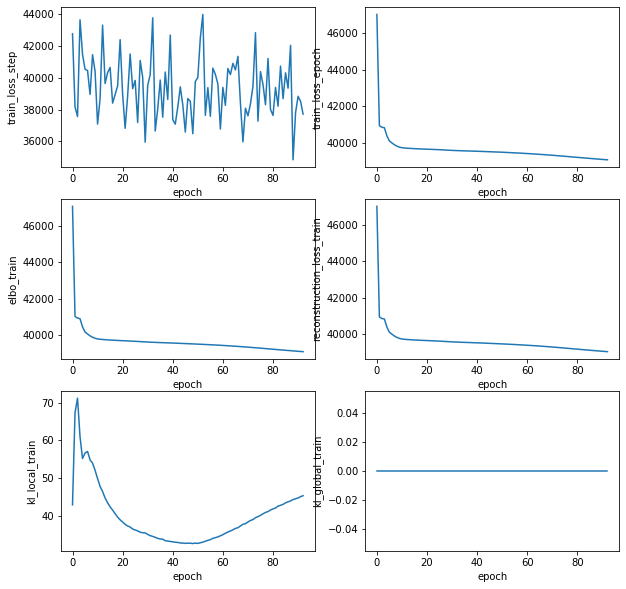

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

sns.lineplot(data=poiss_vi.history['train_loss_step'], x="epoch", y="train_loss_step", ax=axs[0][0])
sns.lineplot(data=poiss_vi.history['train_loss_epoch'], x="epoch", y="train_loss_epoch", ax=axs[0][1])
sns.lineplot(data=poiss_vi.history['elbo_train'], x="epoch", y="elbo_train", ax=axs[1][0])
sns.lineplot(data=poiss_vi.history['reconstruction_loss_train'], x="epoch", y='reconstruction_loss_train', ax=axs[1][1])
sns.lineplot(data=poiss_vi.history['kl_local_train'], x="epoch", y='kl_local_train', ax=axs[2][0])
sns.lineplot(data=poiss_vi.history['kl_global_train'], x="epoch", y='kl_global_train', ax=axs[2][1])

In [14]:
poiss_vi.differential_expression(
    groupby="celltype",
)


DE...:   0%|          | 0/15 [00:00<?, ?it/s]


KeyError: 'px_scale'

In [15]:
adata.obsm["X_poiss_vi"]=poiss_vi.get_latent_representation()
#adata.layers["poiss_vi_normalized"] = poiss_vi.get_normalized_expression(library_size=10e4)

In [20]:
#adata.obsm["X_poiss_vi_pca"] = sc.pp.pca(adata.obsm["X_poiss_vi"])

In [21]:
adata

AnnData object with n_obs × n_vars = 16978 × 164082
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'doublet_calls', 'final_doublets', 'final_doublets_cat', 'nCount_peaks', 'nFeature_peaks', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'peaks.weight', 'sample', 'ident', 'old_index', 'celltype', '_scvi_batch', '_scvi_labels'
    var: 'count', 'percentile', 'n_cells'
    uns: 'X_name', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'LSI', 'UMAP.ATAC', 'X_poiss_vi', 'X_poiss_vi_pca'
    layers: 'logcounts', 'ATAC_counts'

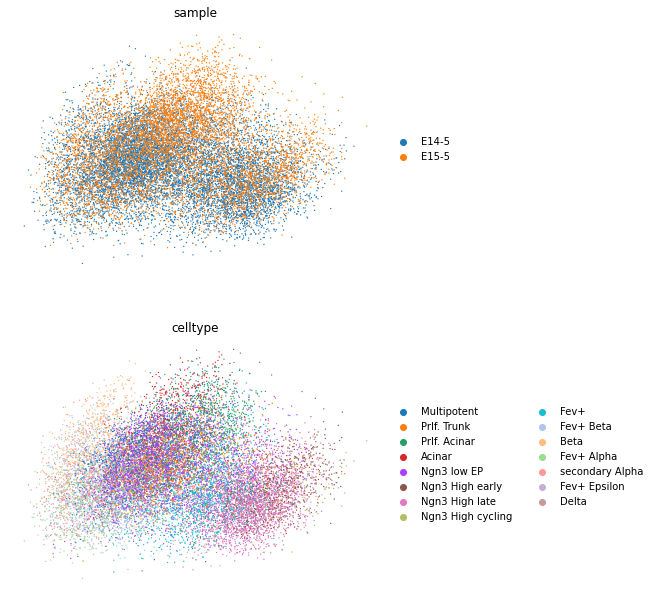

In [16]:
sc.pl.embedding(
    adata,
    basis="X_poiss_vi",
    color=["sample", "celltype"],
    frameon=False,
    ncols=1,
)

In [23]:
adata

AnnData object with n_obs × n_vars = 16978 × 164082
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'doublet_calls', 'final_doublets', 'final_doublets_cat', 'nCount_peaks', 'nFeature_peaks', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'peaks.weight', 'sample', 'ident', 'old_index', 'celltype', '_scvi_batch', '_scvi_labels'
    var: 'count', 'percentile', 'n_cells'
    uns: 'X_name', '_scvi_uuid', '_scvi_manager_uuid', 'sample_colors', 'celltype_colors'
    obsm: 'LSI', 'UMAP.ATAC', 'X_poiss_vi', 'X_poiss_vi_pca'
    layers: 'logcounts', 'ATAC_counts'

In [18]:
sc.pp.neighbors(adata, use_rep="X_poiss_vi")
sc.tl.umap(adata, key_added="poiss_vi")

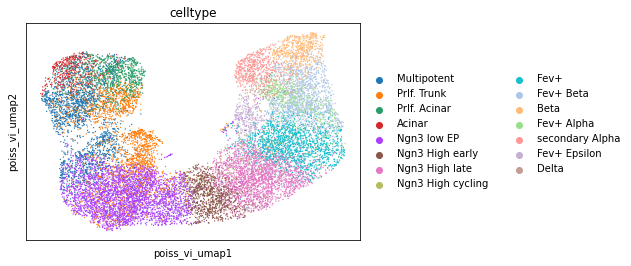

In [19]:
sc.pl.embedding(adata, basis="poiss_vi_umap", color="celltype")

In [16]:
de_df = poiss_vi.differential_expression(
    groupby="celltype",
)
de_df.head()

DE...:   0%|          | 0/15 [00:00<?, ?it/s]


KeyError: 'px_scale'

In [ ]:
markers = {}
cats = adata.obs.celltype.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:3]

In [29]:
for celltype, marks in markers.items():
    title = [f"{celltype}: {mark}" for mark in marks]
    sc.pl.umap(adata, umap_key="poiss_vi_X_umap", color=marks, title=title)

NameError: name 'markers' is not defined

In [20]:
adata.write("/storage/groups/ml01/workspace/dominik.klein/scMultiome_NVF/scMultiome_NVF_E14-E15/E14-E15_adata_with_poiss_VI.h5ad")

In [31]:
poiss_vi.save("/storage/groups/ml01/workspace/dominik.klein/scMultiome_NVF/scMultiome_NVF_E14-E15/models/poiss_vi", overwrite=False, save_anndata=True)